<a href="https://colab.research.google.com/github/DSlaughter01/machine_learning/blob/main/gaussian_processes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------------------------
*Machine Learning Course*

*Master in Information & Health Engineering*

*Vanessa Gómez Verdejo vanessa@tsc.uc3m.es and Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

**Daniel Slaughter** \

**Devashish Sonowal**

# Homework 4: Gaussian Processes

The objective of this practice is to familiarize you with the use of Gaussian Processes, exploring the different extensions that we have seen in the theory session and analyzing the advantages that they can provide us against other models.

For this purpose, in this HW we are going to work with an electrical load estimation problem available in the [UCI data repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency#). Specifically, the problem consists of predicting the heating load (HL) and cooling load (CL) of a set of residential buildings from eight input variables for each building: relative compactness, floor area, wall area, roof area, total height, orientation, glazed area and glazed area distribution.

In [ ]:
# You can install GPy using the following command
!pip install GPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 959 kB 4.2 MB/s 
     |████████████████████████████████| 71 kB 4.5 MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp38-cp38-linux_x86_64.whl size=2783607 sha256=f6ee5736a6860e7a9466a4093ec27f7618ef181811751dca8e87e538ac73dc5b
  Stored in directory: /root/.cache/pip/wheels/48/b3/22/31f07cfd7b182ea3703151b7e5a7d6447e3e1ac6aa5c529413
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=faddd6e2cf1ef954e02c503fe6859c420b432bc2f41254c87b9de9a67449c6da
  Stored in directory: /root/.cache/pip/wheels/66/78/6c/d98cb437834de5e29381786b4ba8a77ea68cca74653ab62713
Successfully built GPy paramz


## Exercise 1. Loading and data set preparation

The following code cell downloads and loads in data set into a dataframe. From this dataframe, divide the data set into training (80%) and test (20%), and normalize the data to zero mean and unit standard deviation.

In [ ]:
import pandas as pd
import GPy
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# import the data from the website
data = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx')

print('A sample of the data:')
print(data.head())

# In case you need it
feature_names = {
    'X1': 'Relative Compactness',
    'X2': 'Surface Area',
    'X3': 'Wall Area',
    'X4': 'Roof Area',
    'X5': 'Overall Height',
    'X6': 'Orientation',
    'X7': 'Glazing Area',
    'X8': 'Glazing Area Distribution' }

A sample of the data:
     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28


In [ ]:
# Indexing for data by position
X = data.iloc[:,0:8].values
Y = data.iloc[:,8:10].values

In [ ]:
# Split and normalize the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print(Y_train.shape)
HL_train, CL_train =  Y_train[:,0], Y_train[:,1]
HL_test, CL_test = Y_test[:,0], Y_test[:,1]

# Normalize the data
transformer = StandardScaler()
transformer.fit(X_train) # fit the transformer
X_train = transformer.transform(X_train) # transform
X_test =  transformer.transform(X_test)

(614, 2)


## Exercise 2. Learning a basic GP (1.5 points)

Now, let's start working with GPs and their implementation with the GPy library. Since we have two output variables, we are going to train two independent GPs, one to estimate HL and one to estimate CL. For each of the two GPs, you have to:

**In the training data set:**.

a) Build a GP regression model based on an RBF kernel.

b) Fit the parameters of the covariance function and the variance of the noise.

**In the test data set:**

c) Calculate the mean absolute error (MAE) and mean squared error (MSE) on the test data using as model output the a posteriori mean or predicted mean of the GP for the optimized hyperparameters.

Finally, compare both results (heat vs cool) taking into account the parameters adjusted by each model.



In [ ]:
# Notes on the steps taken:

# Step 1:
    # We don't have to create a kernel here, as GPRegression defaults to using an RBF kernel.
    # if kernel is None:
        #kernel = kern.RBF(X.shape[1])

    # However, if we did need to do this, we would:
      # Create the kernel as an RBF kernel
      # Include variance and lengthscale, but as their default values, to define the kernel
      # Implement this kernel in a model - one for CL, one for HL

    # The kernel is the covariance matrix - this is automatically included by default

# Step 2:
    # We can display the model parameters using display (before optimisation)

# Step 3:
    # When fitting, we will see how these parameters change.
    # This time, the parameter values have been optimized agains the log marginal likelihood.
    # To check that this is indeed what we want, we could choose random restarts to see if
    # the model arrives at the same conclusion each time (e.g. cl_gp.optimize_restarts(num_restarts = 10))
    # The HL model does not, and tends to fluctuate although always around 740

# Step 4:
    # The default value for the number of samples is 10

In [ ]:
from IPython.display import display
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

train_samp, test_samp = X_train.shape[0], X_test.shape[0]

# Step 1:
cl_gp = GPy.models.GPRegression(X_train, CL_train.reshape(-1, 1))
hl_gp = GPy.models.GPRegression(X_train, HL_train.reshape(-1, 1))

# Step 2:
display(cl_gp)
display(hl_gp)

# Step 3:
# cl_gp.optimize(messages = True)
cl_gp.optimize_restarts(num_restarts = 5)
# hl_gp.optimize(messages = True)
hl_gp.optimize_restarts(num_restarts = 5)

# Step 4: Find the posterior parameters of the test data, after optimisation
cl_posterior_test = cl_gp.posterior_samples_f(X_test)
hl_posterior_test = hl_gp.posterior_samples_f(X_test)

display(cl_gp)
display(hl_gp)
# Plot
# plt.plot(X_train, cl_posterior_test.reshape([-1, train_samp]), '--', lw = 0.5)
# plt.plot(X_train, cl_posterior_test.reshape([-1, train_samp]), '-o', lw = 0.5)
# plt.show()

# Step 5: .optimize fits the function to learn the best hyperparameters. Given this fitted model,
# we call .predict on the test data to get the covariance matrix 'cov_cl/hl', and mean.
pred_cl = cl_gp.predict(X_test, full_cov = True)
pred_hl = hl_gp.predict(X_test, full_cov = True)

# Step 6: Calculate the mean squared error
cl_mse = mean_squared_error(CL_test, pred_cl[0])
hl_mse = mean_squared_error(HL_test, pred_hl[0])

# Step 7: Calculate the mean absolute error
cl_mae = mean_absolute_error(CL_test, pred_cl[0])
hl_mae = mean_absolute_error(HL_test, pred_hl[0])

# Step 8: Display the results
print(f'Cold Load mean absolute error = {cl_mse}')
print(f'Hot Load mean squared error = {hl_mse}')
print(f'Cold Load mean absolute error = {cl_mae}')
print(f'Hot Load mean absolute error = {hl_mae}')

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


Optimization restart 1/5, f = 1355.70276814816
Optimization restart 2/5, f = 1355.7027681484842
Optimization restart 3/5, f = 1355.7027681481638
Optimization restart 4/5, f = 1355.7027681481222
Optimization restart 5/5, f = 1355.70276995629
Optimization restart 1/5, f = 736.2776928588316
Optimization restart 2/5, f = 736.2317717049963
Optimization restart 3/5, f = 736.2489143740172
Optimization restart 4/5, f = 736.9906497673428
Optimization restart 5/5, f = 737.844258265103


GP_regression.,value,constraints,priors
rbf.variance,405.2302692460605,+ve,
rbf.lengthscale,1.9026464927574689,+ve,
Gaussian_noise.variance,1.0675103960987942,+ve,


GP_regression.,value,constraints,priors
rbf.variance,72243188.70348239,+ve,
rbf.lengthscale,16.79683168691435,+ve,
Gaussian_noise.variance,0.1370065087232348,+ve,


Cold Load mean absolute error = 1.9966463407213197
Hot Load mean squared error = 0.33930022100365054
Cold Load mean absolute error = 1.0045214800406688
Hot Load mean absolute error = 0.3836028047399587


**Discussion** Here, we can see that both the mean absolute error and the mean squared error are lower for the Hot Load than for the Cold Load, suggesting a more accurate GP model when predicting Hot Load, whichever metric we used. There was a lot more Gaussian noise variance in the Cold Load GP, but the rbf variance and lengthscales were much lower than in the Cold Load GP.

## Exercise 2 (extension). Safe estimation of the load production  (0.5 points)

The main objective of the load forecasting problem is to have a good estimate of the energy demand in order to adjust the generation to this demand trying to minimize the production excess and minimizing a failure in the system due to lack of energy production (i.e. that we generate less energy than the demand).

In this section we will make use of the predictive distribution of our model to make a conservative estimate of the energy demand. To do so, instead of considering that the energy demanded will be the mean of the predictive distribution we will consider that in the worst case the energy demanded will be the upper limit of the 95% confidence interval which as we know is given by:
$$ y_{\rm IC 95 sup} = y_{\rm mean} + 1.96* y_{\rm std}$$  
where $y_{\rm mean}$ and $y_{\rm std}$ are, respectively, the mean and standard deviation of the predictive distribution of each sample.

Considering that this model output is a conservative estimate of the load demand (for both HL and CL), obtain the total amount of energy that would be produced in each case and the percentage of *system failures*, i.e., the number of times the load demand is greater than the energy produced over the total number of samples in our test set.

Analyze the obatined results, mainly, discussing whether the percentage of *system failures* matches with expected one.

In [ ]:
# We can use predict_quantiles to get the confidence range, according to the GPy documentation
cl_conf_int = cl_gp.predict_quantiles(X_test)
hl_conf_int = hl_gp.predict_quantiles(X_test)

# This returns the a tuple of lower and upper bounds; we can print the first 10 items of
# the CL confidence interval to see this.
print('First 10 CL confidence ranges')
for i in range(10):
  print(cl_conf_int[0][i], cl_conf_int[1][i])

# Then we compare this with the upper limit of the actual results, keeping track of the number of system failures
cl_total_fail, hl_total_fail, cl_tot_en, hl_tot_en, test_samp = 0, 0, 0, 0, CL_test.shape[0]

# We use the second column as the upper bound
for i in range(test_samp):

  # Update total energy
  cl_tot_en += cl_conf_int[1][i]
  hl_tot_en += hl_conf_int[1][i]

  # Compare predicted with actual
  if CL_test[i] > cl_conf_int[1][i]:
    cl_total_fail += 1
  if HL_test[i] > hl_conf_int[1][i]:
    hl_total_fail += 1

# Actual failures as a percentage of total samples
cl_fail_pc, hl_fail_pc = 100*cl_total_fail/test_samp, 100*hl_total_fail/test_samp

print(f'\n{"{:.2f}".format(cl_fail_pc)}% of CL systems failed when using the 95% confidence interval')
print(f'{"{:.2f}".format(hl_fail_pc)}% of HL systems failed when using the 95% confidence interval')

First 10 CL confidence ranges
[15.47191848] [19.9757431]
[11.05767983] [15.92815486]
[35.63481451] [40.39491054]
[18.35827356] [24.3205685]
[29.96362083] [36.23058299]
[29.60617311] [34.98162893]
[26.3899618] [31.53218727]
[30.66148899] [35.45731907]
[28.63197509] [33.83090045]
[25.21134472] [30.20338523]

3.25% of CL systems failed when using the 95% confidence interval
4.55% of HL systems failed when using the 95% confidence interval


## Exercise 3. Analysis of the input feature relevances (2 points)

As we know, we can combine the above GPs design with an ARD (Automatic Relevance Determination) so that each input dimension is weighted with a different scale length in order to analyze the relevance of each variable in the model.

Modify the above design so that the kernel includes an ARD and based on the ARD parameters found, indicate which variables are most important for the regression. Do not forget to include in the kernel design some constant noise term (in case all the input variables drop out of weight).


Next, train a Random Forest for regression and use the `feature_importances` parameter of this model to also analyze the relevance of each variable.

Compare the results with those of the previous model and discuss the similarities or differences between the most relevance features. For this analysis, you may find it useful to analyze the correlations between the input features.

Optimization restart 1/5, f = 1227.1469107788785
Optimization restart 2/5, f = 1230.3241775567456
Optimization restart 3/5, f = 1232.0668868745192
Optimization restart 4/5, f = 1230.6745003887877
Optimization restart 5/5, f = 1227.020648112634
Optimization restart 1/5, f = 635.5263636282914
Optimization restart 2/5, f = 525.8140493510091
Optimization restart 3/5, f = 505.5626033879756
Optimization restart 4/5, f = 561.1893311041086
Optimization restart 5/5, f = 528.1288238178303

The lengthscale values for the CL RBF kernel are: 
   index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |  priors
  [0]    |                         2.08500067  |      +ve      |        
  [1]    |                         3.17036171  |      +ve      |        
  [2]    |                         1.14348222  |      +ve      |        
  [3]    |                       153.30151665  |      +ve      |        
  [4]    |                       118.73730131  |      +ve      |        
  [5]    |               

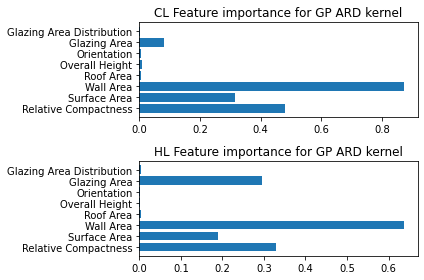

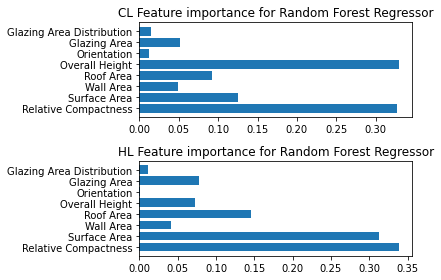

Cold Load mean squared error when using GP with ARD = 3.3576144984889216
Hot Load mean squared error when using GP with ARD = 0.278828647241292
Cold Load mean squared error when using Random Forest = 3.3290172498051955
Hot Load mean squared error when using Random Forest = 0.35826640701558155
Cold Load mean absolute error when using GP with ARD = 1.218814553749509
Hot Load mean absolute error when using GP with ARD = 0.35984386014592695
Cold Load mean absolute error when using Random Forest = 1.0815227272727257
Hot Load mean absolute error when using Random Forest = 0.38636766233766295


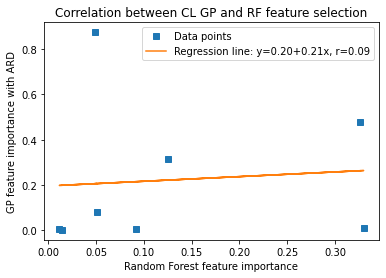

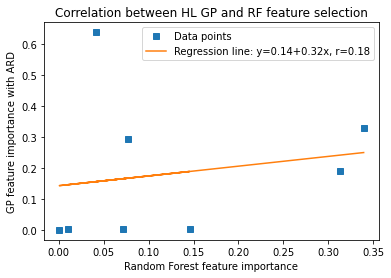

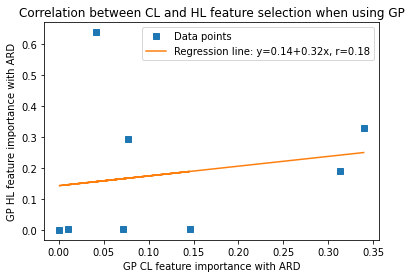

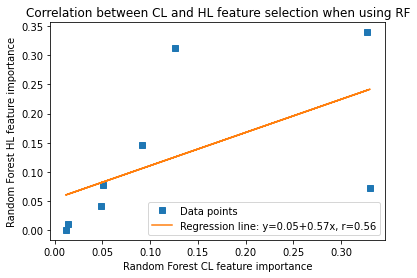

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import scipy.stats

# Define kernel: combine ARD kernel with a white noise kernel
cl_ard_kern = GPy.kern.RBF(X.shape[1], ARD = True) + GPy.kern.White(X.shape[1])
hl_ard_kern = GPy.kern.RBF(X.shape[1], ARD = True) + GPy.kern.White(X.shape[1])

# Create a GP model for each of CL and HL
cl_ard_gp = GPy.models.GPRegression(X_train, CL_train.reshape(-1, 1), cl_ard_kern)
hl_ard_gp = GPy.models.GPRegression(X_train, HL_train.reshape(-1, 1), hl_ard_kern)

# Optimise - The HL model did not converge to 1 value - it generally hovered around 500-700
cl_ard_gp.optimize_restarts(num_restarts = 5)
hl_ard_gp.optimize_restarts(num_restarts = 5)

# Predictions with ARD and a GP
cl_pred_gp = cl_ard_gp.predict(X_test)
hl_pred_gp = hl_ard_gp.predict(X_test)

# Calculate the mean squared error
cl_ard_mse = mean_squared_error(CL_test, cl_pred_gp[0])
hl_ard_mse = mean_squared_error(HL_test, hl_pred_gp[0])

# Calculate the mean absolute error
cl_ard_mae = mean_absolute_error(CL_test, cl_pred_gp[0])
hl_ard_mae = mean_absolute_error(HL_test, hl_pred_gp[0])

# Get the lengthscale for each feature
print(f'\nThe lengthscale values for the CL RBF kernel are: \n {cl_ard_kern.rbf.lengthscale}')
print(f'\nThe lengthscale values for the HL RBF kernel are: \n {hl_ard_kern.rbf.lengthscale}')

cl_feat_imp_gp = list(cl_ard_kern.rbf.lengthscale)
hl_feat_imp_gp = list(hl_ard_kern.rbf.lengthscale)

# The higher the lengthscale value, the lower the importance of the variable
cl_feat_imp_gp = [1/i for i in cl_feat_imp_gp]
hl_feat_imp_gp = [1/i for i in hl_feat_imp_gp]

# Plot a bar chart of the feature importance
feat_list = [str(i) for i in feature_names.values()]
plt.subplot(2, 1, 1)
plt.barh(feat_list, cl_feat_imp_gp)
plt.title('CL Feature importance for GP ARD kernel')
plt.subplot(2, 1, 2)
fig2 = plt.barh(feat_list, hl_feat_imp_gp)
plt.title('HL Feature importance for GP ARD kernel')
plt.tight_layout()
plt.show()

# Create a random forest regressor
cl_for_reg = RandomForestRegressor()
hl_for_reg = RandomForestRegressor()

# Fit and predict
cl_for_reg.fit(X_train, CL_train)
hl_for_reg.fit(X_train, HL_train)

cl_pred_rf = cl_for_reg.predict(X_test)
hl_pred_rf = hl_for_reg.predict(X_test)

#Calculate the mean squared error
cl_rf_mse = mean_squared_error(CL_test, cl_pred_rf)
hl_rf_mse = mean_squared_error(HL_test, hl_pred_rf)

# Calculate the mean absolute error
cl_rf_mae = mean_absolute_error(CL_test, cl_pred_rf)
hl_rf_mae = mean_absolute_error(HL_test, hl_pred_rf)

# Use the feature_importance parameter to analyse feature relevance
plt.subplot(2, 1, 1)
plt.barh(feat_list, cl_for_reg.feature_importances_)
plt.title('CL Feature importance for Random Forest Regressor')
plt.subplot(2, 1, 2)
fig2 = plt.barh(feat_list, hl_for_reg.feature_importances_)
plt.title('HL Feature importance for Random Forest Regressor')
plt.tight_layout()
plt.show()

# Return the MSE of each model:
print(f'Cold Load mean squared error when using GP with ARD = {cl_ard_mse}')
print(f'Hot Load mean squared error when using GP with ARD = {hl_ard_mse}')
print(f'Cold Load mean squared error when using Random Forest = {cl_rf_mse}')
print(f'Hot Load mean squared error when using Random Forest = {hl_rf_mse}')

# Return the MAE of each model:
print(f'Cold Load mean absolute error when using GP with ARD = {cl_ard_mae}')
print(f'Hot Load mean absolute error when using GP with ARD = {hl_ard_mae}')
print(f'Cold Load mean absolute error when using Random Forest = {cl_rf_mae}')
print(f'Hot Load mean absolute error when using Random Forest = {hl_rf_mae}')

# As a comparison, find out the correlation between the different models' feature selection - CL with CL, HL with HL
# CL
x, y = cl_for_reg.feature_importances_, cl_feat_imp_gp
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('Random Forest feature importance')
ax.set_ylabel('GP feature importance with ARD')
ax.legend(facecolor='white')
plt.title('Correlation between CL GP and RF feature selection')
plt.show()

# HL
x, y = hl_for_reg.feature_importances_, hl_feat_imp_gp
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('Random Forest feature importance')
ax.set_ylabel('GP feature importance with ARD')
ax.legend(facecolor='white')
plt.title('Correlation between HL GP and RF feature selection')
plt.show()

# We can do the same for each type of model: GP vs GP (CL and HL) and RF vs RF (CL and HL)
x, y = hl_for_reg.feature_importances_, hl_feat_imp_gp
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('GP CL feature importance with ARD')
ax.set_ylabel('GP HL feature importance with ARD')
ax.legend(facecolor='white')
plt.title('Correlation between CL and HL feature selection when using GP')
plt.show()

x, y = cl_for_reg.feature_importances_, hl_for_reg.feature_importances_
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('Random Forest CL feature importance')
ax.set_ylabel('Random Forest HL feature importance')
ax.legend(facecolor='white')
plt.title('Correlation between CL and HL feature selection when using RF')
plt.show()

**Discussion of the results** \
**Correlation** \
On this run of the code, we can see that there was a very weak positive correlation between the feature importances of GP and RF regressors. However, this is closer to being 0 than to showing any significant relationship. \
The positive correlation was slightly stronger when considering the hot load than the cold load. \
We have also provided a graph of feature importance correlation when using the same model on both cold load and hot load. We can see that the Random Forest Regression model was more inclined to assign a similar feature importance for both hot and cold loads, whereas the correlation was closer to 0 for the GP model. \
The bar charts here show this difference in feature importance for all of the models. Relative compactness, surface area, and wall area, were relatively important in all models, with overall height much less important in GP models than in RF models .\
Several runs of this block of code provided slightly different results, possibly because each GP model did not converge to the same value each time. \
**Accuracy** \
If we use mean squared error as a metric, then GP performed slightly better on both hot and cold loads, whereas if we use mean absolute error as a metric, the converse is true.

## Exercise 4. Improving the GP performance with a good kernel design (2 points)

In this section we are going to try to improve the performance of the previous GP (for both HL and CL) by using a more complicated kernel, in which we combine several covariance functions, and which is able to better fit the data.

Test several kernel designs by making combinations using sums and products and for the best design obtained calculate the performance in terms of MAE and MSE. In addition, analyze if this design allows to improve the performance of the conservative load estimation in terms of total energy generated and presence of faults (extension of Exercise 2). For these designs continue considering the ARD-kernel in order not to lose the interpretability of the model. Among the combinations to check, I advise to include:
* Matern kernel 52   
* Matern kernel 32
* RadQuad

and their linear combinations with RBF kernel.




In [ ]:
# Sums of kernels are themselves kernels
# We can include the 4 kernels above, and form linear combinations
# We can use use the optimum parameters from the previous exercises
# Multipliers for linear combinations

from itertools import combinations

# Individual kernels
m32 = GPy.kern.Matern32(8, ARD = True)
m52 = GPy.kern.Matern52(8, ARD = True)
quad = GPy.kern.RatQuad(8, ARD = True)
rbf = GPy.kern.RBF(8, ARD = True)
white = GPy.kern.White(8)

# Permutations of 2 kernels
ker_list = combinations([m32, m52, quad, rbf], 2)

cl_best_sum_mae = 10000
cl_best_sum_mse = 10000
cl_best_sum_mse_name = "None"
cl_best_sum_mae_name = "None"

hl_best_sum_mae = 10000
hl_best_sum_mse = 10000
hl_best_sum_mse_name = "None"
hl_best_sum_mae_name = "None"

cl_best_prod_mae = 10000
cl_best_prod_mse = 10000
cl_best_prod_mse_name = "None"
cl_best_prod_mae_name = "None"

hl_best_prod_mae = 10000
hl_best_prod_mse = 10000
hl_best_prod_mse_name = "None"
hl_best_prod_mae_name = "None"

# Exploring sums of 2 kernels
for i in list(ker_list):
  comb_kern = i[0] + i[1] + white

  # Create a GP model for each of CL and HL
  cl_gp = GPy.models.GPRegression(X_train, CL_train.reshape(-1, 1), comb_kern)
  hl_gp = GPy.models.GPRegression(X_train, HL_train.reshape(-1, 1), comb_kern)

  # Optimize
  cl_gp.optimize()
  hl_gp.optimize()

  # Predictions with ARD and a GP
  cl_pred = cl_gp.predict(X_test)
  hl_pred = hl_gp.predict(X_test)

  # Calculate the mean squared error
  cl_mse = mean_squared_error(CL_test, cl_pred[0])
  hl_mse = mean_squared_error(HL_test, hl_pred[0])

  if cl_mse < cl_best_sum_mse:
    cl_best_sum_mse = cl_mse
    cl_best_sum_mse_name = comb_kern

  if hl_mse < hl_best_sum_mse:
    hl_best_sum_mse = hl_mse
    hl_best_sum_mse_name = str(i[0]) + str(i[1])

  # Calculate the mean absolute error
  cl_mae = mean_absolute_error(CL_test, cl_pred[0])
  hl_mae = mean_absolute_error(HL_test, hl_pred[0])

  if cl_mae < cl_best_sum_mae:
    cl_best_sum_mae = cl_mae
    cl_best_sum_mae_name = str(i[0]) + str(i[1])

  if hl_mae < hl_best_sum_mae:
    hl_best_sum_mae = hl_mae
    hl_best_sum_mae_name = str(i[0]) + str(i[1])

  print("Done")

# Exploring product of 2 kernels
for i in list(ker_list):

  comb_kern = i[0] * i[1] * white

  # Create a GP model for each of CL and HL
  cl_gp = GPy.models.GPRegression(X_train, CL_train.reshape(-1, 1), comb_kern)
  hl_gp = GPy.models.GPRegression(X_train, HL_train.reshape(-1, 1), comb_kern)

  # Optimise
  cl_gp.optimize()
  hl_gp.optimize()

  # Predictions with ARD and a GP
  cl_pred = cl_gp.predict(X_test)
  hl_pred = hl_gp.predict(X_test)

  # Calculate the mean squared error
  cl_mse = mean_squared_error(CL_test, cl_pred[0])
  hl_mse = mean_squared_error(HL_test, hl_pred[0])

  if cl_mse < cl_best_sum_mse:
    cl_best_sum_mse = cl_mse
    cl_best_sum_mse_name = str(i[0]) + str(i[1])

  if hl_mse < hl_best_prod_mse:
    hl_best_prod_mse = hl_mse
    hl_best_prod_mse_name = str(i[0]) + str(i[1])

  # Calculate the mean absolute error
  cl_mae = mean_absolute_error(CL_test, cl_pred[0])
  hl_mae = mean_absolute_error(HL_test, hl_pred[0])

  if cl_mae < cl_best_prod_mae:
    cl_best_prod_mae = cl_mae
    cl_best_prod_mae_name = str(i[0]) + str(i[1])

  if hl_mae < hl_best_prod_mae:
    hl_best_prod_mae = hl_mae
    hl_best_prod_mae_name = str(i[0]) + str(i[1])

  print("Done")

# Print the results
print(f'The lowest CL MAE when using the sum of two kernels with ARD is: {cl_best_sum_mae}, obtained when using {cl_best_sum_mae_name}')
print(f'The lowest CL MSE when using the sum of two kernels with ARD is: {cl_best_sum_mse}, obtained when using {cl_best_sum_mse_name}')
print(f'The lowest HL MAE when using the sum of two kernels with ARD is: {hl_best_sum_mae}, obtained when using {hl_best_sum_mae_name}')
print(f'The lowest HL MSE when using the sum of two kernels with ARD is: {hl_best_sum_mse}, obtained when using {hl_best_sum_mse_name}')
print(f'The lowest CL MAE when using the product of two kernels with ARD is: {cl_best_prod_mae}, obtained when using {cl_best_prod_mae_name}')
print(f'The lowest CL MSE when using the product of two kernels with ARD is: {cl_best_prod_mse}, obtained when using {cl_best_prod_mse_name}')
print(f'The lowest HL MAE when using the product of two kernels with ARD is: {hl_best_prod_mae}, obtained when using {hl_best_prod_mae_name}')
print(f'The lowest HL MSE when using the product of two kernels with ARD is: {hl_best_prod_mse}, obtained when using {hl_best_prod_mse_name}')


Done
Done
Done
Done
Done
Done
The lowest CL MAE when using the sum of two kernels with ARD is: 344.2802276695868, obtained when using   Mat52.       |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |   (8,)  |      +ve      |          RatQuad.     |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |   (8,)  |      +ve      |        
  power        |    2.0  |      +ve      |        
The lowest CL MSE when using the sum of two kernels with ARD is: 10000, obtained when using None
The lowest HL MAE when using the sum of two kernels with ARD is: 0.17387721679864976, obtained when using   Mat52.       |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |   (8,)  |      +ve      |          rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |   (8,)  |      +ve      |        
Th

In [ ]:
# We can then take the best model, calculate its 95% confidence interval, and compare it with the first model.
# In our case it was the same for HL and CL
sum_cl_kern = m52 + quad + white
sum_hl_kern = m52 + rbf + white

cl_comp_model = GPy.models.GPRegression(X_train, CL_train.reshape(-1, 1), sum_cl_kern)
hl_comp_model = GPy.models.GPRegression(X_train, HL_train.reshape(-1, 1), sum_hl_kern)

cl_comp_model.optimize()
hl_comp_model.optimize()

# We can use predict_quantiles to get the confidence range, according to the GPy documentation
cl_comp_conf_int = cl_comp_model.predict_quantiles(X_test)
hl_comp_conf_int = hl_comp_model.predict_quantiles(X_test)

# Then we compare this with the upper limit of the actual results, keeping track of the number of system failures
cl_new_total_fail, hl_new_total_fail = 0, 0
cl_new_tot_en, hl_new_tot_en = 0, 0

# We use the second column as the upper bound
for i in range(test_samp):

  # Update total energy
  cl_new_tot_en += cl_comp_conf_int[1][i]
  hl_new_tot_en += hl_conf_int[1][i]

  # Compare predicted with actual
  if CL_test[i] > cl_comp_conf_int[1][i]:
    cl_new_total_fail += 1
  if HL_test[i] > hl_comp_conf_int[1][i]:
    hl_new_total_fail += 1

# Actual failures as a percentage of total samples
cl_new_fail_pc, hl_new_fail_pc = 100*cl_new_total_fail/test_samp, 100*hl_new_total_fail/test_samp

# Print the results
print(f'\n{"{:.2f}".format(cl_new_fail_pc)}% of CL systems failed when using the 95% confidence interval')
print(f'This was a difference of {cl_new_fail_pc - cl_fail_pc}% compared with the result when using an RBF kernel')
print(f'{"{:.2f}".format(hl_new_fail_pc)}% of HL systems failed when using the 95% confidence interval')
print(f'This was a difference of {hl_new_fail_pc - hl_fail_pc}% compared with the result when using an RBF kernel')

print(f'The total amount of energy produced in CL when using the 95% confidence interval was {cl_new_tot_en}')
print(f'This was a difference of {cl_new_tot_en - cl_tot_en}% compared with the result when using an RBF kernel')
print(f'The total amount of energy produced in CL when using the 95% confidence interval was {hl_new_tot_en}')
print(f'This was a difference of {hl_new_tot_en - cl_tot_en}% compared with the result when using an RBF kernel')


0.00% of CL systems failed when using the 95% confidence interval
This was a difference of -3.2467532467532467% compared with the result when using an RBF kernel
8.44% of HL systems failed when using the 95% confidence interval
This was a difference of 3.896103896103896% compared with the result when using an RBF kernel
The total amount of energy produced in CL when using the 95% confidence interval was [3967.8780119]
This was a difference of [-296.16205487]% compared with the result when using an RBF kernel
The total amount of energy produced in CL when using the 95% confidence interval was [3645.69694901]
This was a difference of [-618.34311776]% compared with the result when using an RBF kernel


**Discussion of the results** \
**System failures**:
Using a custom kernel over the range that we explored was beneficial in the Cold Load case, reducibg the percentage of system failures to 0. However, in the Hot Load case, the percentage of system failures almost doubled.\
**Success of kernel combinations**:
When exploring a range of sums and products of kernels, most of the models failed to give an MSE which was less than 10,000. The only ones that did were the combination of RBF and Mat52, and RBF and RatQuad (but even this last combination produced bad results in terms of our metrics. \
**Energy production** \
The total energy production decreased in both cases. In the case of CL, this means we were successful, as we managed to reduce both system failures (to 0) and energy production, suggesting an optimal distribution of energy over all of the houses. Although energy production in HL decreased, this is not a sign of improvement since our goal was to minimise system failures, which almost doubled.


For the remainder of the practice consider as kernel the sum of a RBF and a Matern52 kernel with ARD.

## Exercise 5. Comparison with Kernel Ridge Regression (KRR) (1 point)

As we have seen in the theory session, the predictive mean of our GP (linear) matches the solution of the Ridge Regression model, and the same is true if we use kernel versions in both models. However, there are significant differences between the two models that we will analyze in this section.

To do this, solve the above problems (HL and CL) using a KRR and analyze how they perform in performance (MAE and MSE), training and test times.

If for the KRR model you want to use a complex kernel (for instance, the sum of a RBF and a Matern52 kernel) you can use those from [sklearn's GP kernel library](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes) with the KRR model. In this case, be careful how you explore the model parameters to prevent the cross-validation process from being endless.

Finally, discuss the advantages/disadvantages of this model in comparison to GPs.


## Discussion

**Linear KRR vs Linear GP.**


1.   The mean absolute errors obtained using both the models are similar. On the other hand, the mean squared errors obtained using Linear KRR are slightly better than those obtained using Linear GP. These are in accordance with what we have seen in the theory session.
2.   We observe that Linear KRR (~ 0.05s) is much much faster than Linear GP (~1.9s). Therefore, we expect the former to be prefered in practice.

**RBF KRR vs RBF GP.**


1.   The MSE and MAE obtained using RBF KRR are slightly better than those obtained using RBF GP in Exercise 2. However, with proper optimization, we expect RBF GP to produce lower MSE and MAE.
2.   We observe that RBF KRR (~ 0.05s) is much much faster than RBF GP (~1.9s). Therefore, we expect the former to be prefered in practice.

Moreover, we see that the MSE and MAE provided by the linear models are much worse than those provided by the models based on RBF. Therefore, we can conclude that the given dataset is best described using a nonlinear model.

Note: We can cross validate the parameters in the KRR models to get optimal MSE and MAE. However, the MAE and MSE we obtained are comparable and even better than those obtained using GP.



In [ ]:
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import time

In [ ]:
#@title Using Linear KRR

# heating
start=time.time()
ridgeLin_hl = KRR(alpha=0.01, kernel='linear', gamma=0.1) #High a = allow errors, High Gamma = overfitted
ridgeLin_hl.fit(X_train, HL_train)

# Predictions and metrics
Ypred_ridgeLin_hl = ridgeLin_hl.predict(X_test)
maeLin_HL = mean_absolute_error(HL_test, Ypred_ridgeLin_hl)
mseLin_HL=mean_squared_error(HL_test, Ypred_ridgeLin_hl)
stop=time.time()

print(f"The MAE for HL is: {maeLin_HL}")
print(f"The MSE for HL is: {mseLin_HL}")
print(f"Time taken: {stop-start} seconds\n")

# cooling
start=time.time()
ridgeLin_cl = KRR(alpha=0.01, kernel='linear', gamma=0.1)
ridgeLin_cl.fit(X_train, CL_train)

# Predictions and metrics
Ypred_ridgeLin_cl = ridgeLin_cl.predict(X_test)
maeLin_cl = mean_absolute_error(CL_test, Ypred_ridgeLin_cl)
mseLin_cl = mean_squared_error(CL_test, Ypred_ridgeLin_cl)
stop=time.time()
print("CL MAE: ", maeLin_cl)
print("CL MSE: ", mseLin_cl)
print("Time taken: "+str(stop-start)+' sec')

The MAE for HL is: 22.350700727251862
The MSE for HL is: 509.62377946769266
Time taken: 0.04628300666809082 seconds

CL MAE:  24.37159498031582
CL MSE:  604.6552016388241
Time taken: 0.040075063705444336 sec


In [ ]:
#@title Using RBF KKR

# heating
start = time.time()

# Define and train our model
ridgeRbf_hl = KRR(alpha=0.0001, kernel='rbf', gamma=0.1)
ridgeRbf_hl.fit(X_train, HL_train)

# Predictions and metrics
Ypred_ridgeRbf_hl = ridgeRbf_hl.predict(X_test)
mae_hl=mean_absolute_error(HL_test, Ypred_ridgeRbf_hl)
mse_hl=mean_squared_error(HL_test, Ypred_ridgeRbf_hl)
stop=time.time()

print(f"Hot Load MAE: {mae_hl}")
print(f"Hot Load MSE: {mse_hl}")
print(f"Time taken: {stop - start} seconds\n")

# cooling
start = time.time()

# Define and train our model
ridgeRbf_cl = KRR(alpha=0.001, kernel='rbf', gamma=0.1)
ridgeRbf_cl.fit(X_train, CL_train)

# Predictions and metrics
Ypred_ridgeRbf_cl = ridgeRbf_cl.predict(X_test)
mae_cl = mean_absolute_error(CL_test, Ypred_ridgeRbf_cl)
mse_cl = mean_squared_error(CL_test, Ypred_ridgeRbf_cl)
stop = time.time()

print(f"Hot Load MAE: {mae_cl}")
print(f"Hot Load MSE: {mse_cl}")
print(f"Time taken: {stop - start} seconds\n")


Hot Load MAE: 0.3790014565519538
Hot Load MSE: 0.30367397930638124
Time taken: 0.07214593887329102 seconds

Hot Load MAE: 0.9878596360483645
Hot Load MSE: 1.9668527874227166
Time taken: 0.07538723945617676 seconds



In [ ]:
#@title Using Linear Gaussian Process

# heating
print("Heating Load:\n")

start = time.time()

# Define and train our model
lin_kernel = GPy.kern.Linear(input_dim=8)
m_l_hl = GPy.models.GPRegression(X_train,HL_train.reshape(-1,1),lin_kernel)
m_l_hl.optimize_restarts(num_restarts = 5)

display(m_l_hl)

# Predictions and errors
pred_l_hl = m_l_hl.predict(X_test)
mse_l_hl = mean_squared_error(HL_test,pred_l_hl[0])
mae_l_hl = mean_absolute_error(HL_test, pred_l_hl[0])
stop = time.time()

print(f"Hot Load MAE: {mae_l_hl}")
print(f"Hot Load MSE: {mse_l_hl}")
print(f"Time taken: {stop - start} seconds")

# cooling
print("\nCooling Load:\n")
start = time.time()

# Define and train our model
lin_kernel = GPy.kern.Linear(input_dim=8)
m_l_cl = GPy.models.GPRegression(X_train,CL_train.reshape(-1,1),lin_kernel)
m_l_cl.optimize_restarts(num_restarts = 5)
display(m_l_cl)

# Predict and errors
pred_l_cl = m_l_cl.predict(X_test)
mse_l_cl = mean_squared_error(CL_test,pred_l_cl[0])
mae_l_cl = mean_absolute_error(CL_test, pred_l_cl[0])
stop=time.time()

print(f"Cool Load MAE {mae_l_cl}")
print(f"Cool Load MSE {mse_l_cl}")
print(f"Time taken: {stop - start} seconds")

Heating Load:

Optimization restart 1/5, f = 2789.462476905267
Optimization restart 2/5, f = 2789.4624769060556
Optimization restart 3/5, f = 2789.462476905265
Optimization restart 4/5, f = 2789.4624769343295
Optimization restart 5/5, f = 2789.462476905286


GP_regression.,value,constraints,priors
linear.variances,8.011618442608038,+ve,
Gaussian_noise.variance,505.7384991060263,+ve,


Hot Load MAE: 22.348780805765344
Hot Load MSE: 513.1916922294686
Time taken: 10.005203008651733 seconds

Cooling Load:

Optimization restart 1/5, f = 2850.167711038378
Optimization restart 2/5, f = 2850.1677110371497
Optimization restart 3/5, f = 2850.1677110371497
Optimization restart 4/5, f = 2850.1677110371747
Optimization restart 5/5, f = 2850.1677110875385


GP_regression.,value,constraints,priors
linear.variances,6.423650386617924,+ve,
Gaussian_noise.variance,618.3683414218469,+ve,


Cool Load MAE 24.37307231721667
Cool Load MSE 608.6321773011739
Time taken: 11.561689615249634 seconds


## Exercise 6. Using sparse GPs (2 points)

Implement a sparse version of the above GPs optimized to find a set of **inducing points** on which the GP can rely to make the prediction. Measure the performance of the model (analyze the marginal likelihood of the model and the MSE) for 20, 40 and 100 inducing points and discuss whether the sparse solution is adequate.



As expected, we get better MSE and MAE as the number of including points increase, and the execution times also increase accordingly. Considering we are only using a sparse dataset, the MSE and MAE are quite good.

We also observe,as expected, that the log likelihood decreases in magnitude as the number of including points increase.

The execution time of the full data GP is around 50 seconds, which is much higher than the execution times we have obtained above using sparse GP. Therefore, we see that the sparse version gives us considerable improvement vis-a-vis time.

In [ ]:
inducing_points = [20,40,100]
mse_sparse_hl = []
mae_sparse_hl = []
mse_sparse_cl = []
mae_sparse_cl = []
log_likelihood_cl = []
log_likelihood_hl = []
index = 0
for i in inducing_points:

  start_hl = time.time()

  # for Heating
  # Define inducing points
  Z = np.random.rand(i,8)*2
  hlSparse_gp = GPy.models.SparseGPRegression(X_train, HL_train.reshape(-1,1),Z=Z)
  # Likelihood Variance
  hlSparse_gp.likelihood.variance = 0.05
  # Fixing Inducing Points
  hlSparse_gp.inducing_inputs.fix()
  hlSparse_gp.optimize('bfgs')
  # Prediction
  pred_hl = hlSparse_gp.predict(X_test)
  mse_hl_sp = mean_squared_error(HL_test,pred_hl[0])
  mae_hl_sp = mean_absolute_error(HL_test,pred_hl[0])

  stop_hl=time.time()


  # for Cooling

  start_cl=time.time()

  #Define inducing points
  Z = np.random.rand(i,8)*1
  clSparse_gp = GPy.models.SparseGPRegression(X_train, CL_train.reshape(-1,1),Z=Z)
  #Likelihood Variance
  clSparse_gp.likelihood.variance = 0.05
  #Fixing Inducing Points
  clSparse_gp.inducing_inputs.fix()
  clSparse_gp.optimize('bfgs')
  # Prediction
  pred_cl = clSparse_gp.predict(X_test)
  mse_cl_sp = mean_squared_error(CL_test,pred_cl[0])
  mae_cl_sp = mean_absolute_error(CL_test,pred_cl[0])

  stop_cl=time.time()

  # update array entries
  mae_sparse_hl.append(mae_hl_sp)
  mse_sparse_hl.append(mse_hl_sp)
  mae_sparse_cl.append(mae_cl_sp)
  mse_sparse_cl.append(mse_cl_sp)
  log_likelihood_cl.append(hlSparse_gp.log_likelihood())
  log_likelihood_hl.append(clSparse_gp.log_likelihood())

  # Print outputs
  print("Inducing point: " + str(i))
  print("Mean Absolute error of Heating Load: " + str(mae_sparse_hl[index]))
  print("Mean Absolute error of Cooling Load: " + str(mae_sparse_cl[index]))
  print("Mean Squared error of Heating Load: " + str(mse_sparse_hl[index]))
  print("Mean Squared error of Cooling Load: " + str(mse_sparse_cl[index]))
  print("Marginal Likelihood of Heating Load Model: " + str(log_likelihood_hl[index][0][0]))
  print("Marginal Likelihood of Cooling Load Model: " + str(log_likelihood_cl[index][0][0]))
  print('Execution time of Heating Load is ' + str(stop_hl-start_hl)+' seconds.')
  print('Execution time of Cooling Load is ' + str(stop_cl-start_cl)+' seconds.')
  print("")
  index = index+1

Inducing point: 20
Mean Absolute error of Heating Load: 2.2133302461697215
Mean Absolute error of Cooling Load: 2.221297031484277
Mean Squared error of Heating Load: 10.059875430085775
Mean Squared error of Cooling Load: 10.604081146543118
Marginal Likelihood of Heating Load Model: -1610.978827695184
Marginal Likelihood of Cooling Load Model: -1554.9437392345608
Execution time of Heating Load is 1.5954115390777588 seconds.
Execution time of Cooling Load is 2.00040340423584 seconds.

Inducing point: 40
Mean Absolute error of Heating Load: 2.0077929470944404
Mean Absolute error of Cooling Load: 2.099525959650312
Mean Squared error of Heating Load: 8.463853675399077
Mean Squared error of Cooling Load: 9.613622321247878
Marginal Likelihood of Heating Load Model: -1596.765530061508
Marginal Likelihood of Cooling Load Model: -1517.2402848482707
Execution time of Heating Load is 1.919316291809082 seconds.
Execution time of Cooling Load is 1.8161940574645996 seconds.

Inducing point: 100
Mean 

## Exercise 7. Comparison with a SVR (1 point)

To fully analyze the advantages of the sparse GP we have just designed compare its performance (MSE, MAE and training and execution times) with a Support Vector Machine for regression which as we know is also able to provide sparse solutions. Compare also the sparsity of both solutions, choose the sparse GP from the previous section that you consider more suitable and compare its number of *inducing points* with the number of support vectors of the SVR.

For the SVR you can use either a RBF kernel or a complex one (for instance RBF+MAtern52) using the GP kernel library.



## Discussion

The number of support vectors used by the SVR models is 550+, which is greater than the number of including points. However, the execution times of the SVR models is much lower than the sparse GP.

**Using sparse GP (100 including points):**

Mean Squared error of Heating Load: 5.087977051138854

Mean Absolute error of Heating Load: 1.731796786642887

Mean Squared error of Cooling Load: 8.05089437434583

Mean Absolute error of Cooling Load: 1.9235544001173182


**Using SVR:**

Mean squared error for HL is 9.12723316237592

Mean absolute error for HL is 2.0142352099114693

Mean squared error for CL is 16.067639972873643

Mean absolute error for CL is 3.0071729146976587

The MAE and MSE values obtained using sparse GP are much better than the SVR.

In [ ]:
#@title Heating SVR
from sklearn.svm import SVR
import time

start = time.time()
regressor_hl = SVR(kernel = 'rbf')
regressor_hl.fit(X_train, HL_train)
y_pred_hl = regressor_hl.predict(X_test)
suppvec_hl=regressor_hl.support_vectors_

print('Execution time is ' +str(time.time()-start) +' seconds.')
print('Number of support vectors is ' +str(suppvec_hl.shape[0]))
print('Mean squared error for HL is ' +str(mean_squared_error(y_pred_hl, HL_test)))
print('Mean absolute error for HL is '+str(mean_absolute_error(y_pred_hl, HL_test)))


Execution time is 0.07908058166503906 seconds.
Number of support vectors is 569
Mean squared error for HL is 9.12723316237592
Mean absolute error for HL is 2.0142352099114693


In [ ]:
#@title Cooling SVR

start=time.time()
regressor_cl = SVR(kernel = 'rbf')
regressor_cl.fit(X_train, CL_train)
y_pred_cl = regressor_cl.predict(X_test)
suppvec_cl=regressor_cl.support_vectors_

print('Execution time is ' +str(time.time()-start) +' seconds.')
print('Number of support vectors is ' +str(suppvec_cl.shape[0]))
print('Mean squared error for CL is ' +str(mean_squared_error(y_pred_hl, CL_test)))
print('Mean absolute error for CL is '+str(mean_absolute_error(y_pred_hl, CL_test)))


Execution time is 0.03910112380981445 seconds.
Number of support vectors is 576
Mean squared error for CL is 16.067639972873643
Mean absolute error for CL is 3.0071729146976587
